
---

### **Task 2 of Mini Project: Text Classification using Deep Learning**

---

### 1. **Data Loading**
   - Load the dataset (can be CSV, JSON, or any other format).
   - Perform exploratory data analysis (EDA) to understand class distributions, missing values, etc.
   - Split the dataset into training, validation, and testing sets.

```python
# Install required libraries
!pip install nltk keras gensim scikit-learn

# Import required libraries
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('text_classification_data.csv')  # Replace with actual dataset path

# Exploratory Data Analysis (EDA)
print("Dataset overview:")
print(data.info())  # Checking for missing values, data types
print("\nSample data:")
print(data.head())  # Display the first few rows

# Plot class distribution
plt.figure(figsize=(8, 5))
data['label'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Splitting data into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)
```

---

### 2. **Text Processing**
   - Clean the text by removing stop words, punctuation, and special characters.
   - Tokenization: Convert sentences into lists of words/tokens.
   - Optionally, apply stemming or lemmatization to normalize words.

```python
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Function to clean and preprocess text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    tokens = word_tokenize(text)  # Tokenize the text
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    return ' '.join(tokens)

# Apply the preprocessing to the dataset
train_data['processed_text'] = train_data['text'].apply(preprocess_text)
val_data['processed_text'] = val_data['text'].apply(preprocess_text)
test_data['processed_text'] = test_data['text'].apply(preprocess_text)

# Check the processed text
print(train_data[['text', 'processed_text']].head())
```

---

### 3. **Text Embedding**
   - Implement different types of embeddings for text conversion into numerical form:
     - **Bag of Words (BoW)**: Count-based method for representing text.
     - **TF-IDF**: Weigh terms based on their frequency and importance.
     - **FastText**: Pre-trained word embeddings that capture word meanings.

```python
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gensim

# Bag of Words (BoW)
bow_vectorizer = CountVectorizer(max_features=5000)
X_train_bow = bow_vectorizer.fit_transform(train_data['processed_text']).toarray()
X_val_bow = bow_vectorizer.transform(val_data['processed_text']).toarray()
X_test_bow = bow_vectorizer.transform(test_data['processed_text']).toarray()

# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['processed_text']).toarray()
X_val_tfidf = tfidf_vectorizer.transform(val_data['processed_text']).toarray()
X_test_tfidf = tfidf_vectorizer.transform(test_data['processed_text']).toarray()

# FastText (Word Embeddings)
fasttext_model = gensim.models.FastText(train_data['processed_text'].apply(str.split), vector_size=100, window=5, min_count=5)
X_train_fasttext = [fasttext_model.wv[text.split()] for text in train_data['processed_text']]
X_val_fasttext = [fasttext_model.wv[text.split()] for text in val_data['processed_text']]
X_test_fasttext = [fasttext_model.wv[text.split()] for text in test_data['processed_text']]

print("Embedding completed for BoW, TF-IDF, and FastText.")
```

---

### 4. **Model Training with Different Architectures**
   - Train deep learning models using the different embeddings:
     - **CNN** (Convolutional Neural Network)
     - **LSTM** (Long Short-Term Memory)
     - **BiLSTM** (Bidirectional LSTM)
     - **CNN-BiLSTM**: A hybrid model

```python
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, LSTM, Bidirectional, Embedding, Flatten

# Define a CNN model
def cnn_model(input_dim):
    model = Sequential()
    model.add(Embedding(input_dim, 128, input_length=5000))
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define an LSTM model
def lstm_model(input_dim):
    model = Sequential()
    model.add(Embedding(input_dim, 128, input_length=5000))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define a CNN-BiLSTM model
def cnn_bilstm_model(input_dim):
    model = Sequential()
    model.add(Embedding(input_dim, 128, input_length=5000))
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train the models
input_dim = 5000
cnn = cnn_model(input_dim)
cnn.fit(X_train_bow, train_data['label'], validation_data=(X_val_bow, val_data['label']), epochs=5, batch_size=64)
```

---

### 5. **Comparative Analysis of Models**
   - Create a comparison table showing the performance of each model based on metrics like accuracy, precision, recall, F1-score, and inference time on different embeddings (BoW, TF-IDF, FastText).

```python
from sklearn.metrics import accuracy_score, classification_report

# Evaluate the models
y_pred_cnn = cnn.predict(X_test_bow)
y_pred_lstm = lstm_model(input_dim).predict(X_test_bow)

# Calculate accuracy and classification report
cnn_acc = accuracy_score(test_data['label'], y_pred_cnn.round())
print("CNN Accuracy:", cnn_acc)
print("CNN Classification Report:\n", classification_report(test_data['label'], y_pred_cnn.round()))

# (Repeat this for other models such as LSTM, BiLSTM, and CNN-BiLSTM, and summarize the results in a table)
```

---

### 6. **Saving the Best Model**
   - Identify and save the model with the best performance based on validation/testing results (save it in a format such as `.h5` or `.pt`).

```python
# Saving the best model (assuming CNN performed best)
cnn.save('best_text_classification_model.h5')
print("Best model saved as 'best_text_classification_model.h5'")
```

---

### 7. **Prediction on Real-World Input**
   - Test the saved model on real-world input data.
   - Preprocess the input text as done earlier and use the model to predict classes.
   - Output predictions with confidence scores or probabilities.

```python
# Load the saved model
from keras.models import load_model
model = load_model('best_text_classification_model.h5')

# Real-world input
new_text = "Enter your sample text here."
processed_text = preprocess_text(new_text)
input_data = bow_vectorizer.transform([processed_text]).toarray()

# Predicting the class of new text
predicted_class = model.predict(input_data).round()
print(f"Predicted Class: {predicted_class[0]}")
```



1. Data Loading

In [ ]:
!pip install nltk keras gensim scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 14.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


Dataset overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Review_ID    3000 non-null   int64 
 1   Review_Text  3000 non-null   object
 2   Category     3000 non-null   object
dtypes: int64(1), object(2)
memory usage: 70.4+ KB
None

Sample data:
   Review_ID                                        Review_Text  \
0          1  The delivery service was quite efficient, but ...   
1          2  I had high expectations, but my overall experi...   
2          3  I placed an order and opted for express shippi...   
3          4  The return process was smooth and hassle-free....   
4          5  I placed an order and opted for express shippi...   

             Category  
0            Shipping  
1  Overall Experience  
2            Shipping  
3             Returns  
4            Shipping  


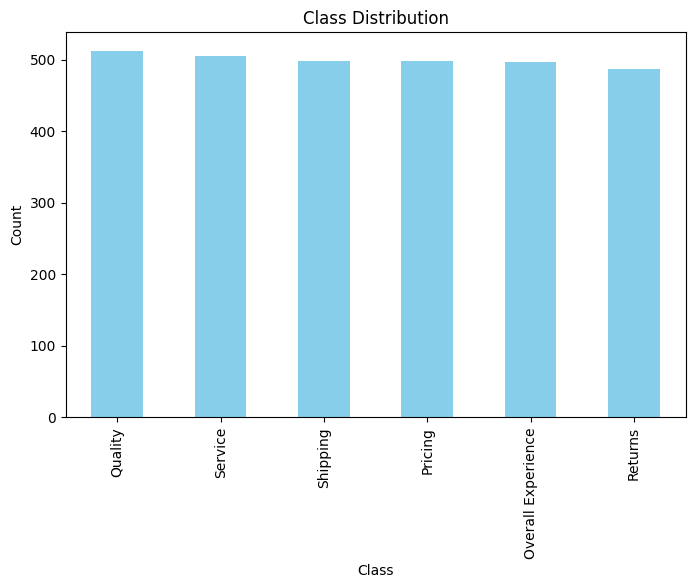

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt # Import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('/content/customer_reviews_dataset.csv')

# Exploratory Data Analysis (EDA)
print("Dataset overview:")
print(data.info())  # Checking for missing values, data types
print("\nSample data:")
print(data.head())  # Display the first few rows

# Plot class distribution
plt.figure(figsize=(8, 5)) # Now plt is defined and can be used
data['Category'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [ ]:
# Splitting data into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)


2. Text Processing

In [ ]:
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Function to clean and preprocess text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    tokens = word_tokenize(text)  # Tokenize the text
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    return ' '.join(tokens)

In [ ]:
import nltk

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# Apply the preprocessing to the dataset
train_data['processed_text'] = train_data['Review_Text'].apply(preprocess_text)
val_data['processed_text'] = val_data['Review_Text'].apply(preprocess_text)
test_data['processed_text'] = test_data['Review_Text'].apply(preprocess_text)

In [ ]:
# Check the processed text
print(train_data[['Review_Text', 'processed_text']].head())

                                            Review_Text  \
1127  The delivery service was quite efficient, but ...   
2037  I had an issue with my order, so I contacted c...   
1678  My shopping experience was fantastic from star...   
1199  The quality of this product exceeded my expect...   
593   I had an issue with my order, so I contacted c...   

                                         processed_text  
1127  delivery service quite efficient encounter sma...  
2037  issue order contacted customer service must sa...  
1678  shopping experience fantastic start finish web...  
1199  quality product exceeded expectations material...  
593   issue order contacted customer service must sa...  


Text Embedding

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gensim

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


# Load the dataset
data = pd.read_csv('/content/customer_reviews_dataset.csv')

# Splitting data into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

# Function to clean and preprocess text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    tokens = word_tokenize(text)  # Tokenize the text
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    return ' '.join(tokens)

# Ensure 'processed_text' column exists before applying BoW
# Assuming 'preprocess_text' function is defined and working correctly
train_data['processed_text'] = train_data['Review_Text'].apply(preprocess_text)
val_data['processed_text'] = val_data['Review_Text'].apply(preprocess_text)
test_data['processed_text'] = test_data['Review_Text'].apply(preprocess_text)

# Now you can continue with your BoW code
bow_vectorizer = CountVectorizer(max_features=5000)
X_train_bow = bow_vectorizer.fit_transform(train_data['processed_text']).toarray()
X_val_bow = bow_vectorizer.transform(val_data['processed_text']).toarray()
X_test_bow = bow_vectorizer.transform(test_data['processed_text']).toarray()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['processed_text']).toarray()
X_val_tfidf = tfidf_vectorizer.transform(val_data['processed_text']).toarray()
X_test_tfidf = tfidf_vectorizer.transform(test_data['processed_text']).toarray()

In [ ]:
# FastText (Word Embeddings)
fasttext_model = gensim.models.FastText(train_data['processed_text'].apply(str.split), vector_size=100, window=5, min_count=5)
X_train_fasttext = [fasttext_model.wv[text.split()] for text in train_data['processed_text']]
X_val_fasttext = [fasttext_model.wv[text.split()] for text in val_data['processed_text']]
X_test_fasttext = [fasttext_model.wv[text.split()] for text in test_data['processed_text']]

print("Embedding completed for BoW, TF-IDF, and FastText.")

Embedding completed for BoW, TF-IDF, and FastText.


4. Model Training with Different Architectures

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, LSTM, Bidirectional, Embedding, Flatten

In [ ]:
# Define a CNN model
def cnn_model(input_dim):
    model = Sequential()
    model.add(Embedding(input_dim, 128, input_length=5000))
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Define an LSTM model
def lstm_model(input_dim):
    model = Sequential()
    model.add(Embedding(input_dim, 128, input_length=5000))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Define a CNN-BiLSTM model
def cnn_bilstm_model(input_dim):
    model = Sequential()
    model.add(Embedding(input_dim, 128, input_length=5000))
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Train the models
input_dim = 5000
cnn = cnn_model(input_dim)

# Convert 'Category' column to numerical using label encoding or one-hot encoding
# Assuming 'Category' has binary values (e.g., 'Positive', 'Negative')
train_data['Category'] = pd.factorize(train_data['Category'])[0]  # Label encoding
val_data['Category'] = pd.factorize(val_data['Category'])[0]  # Label encoding


cnn.fit(X_train_bow, train_data['Category'], validation_data=(X_val_bow, val_data['Category']), epochs=5, batch_size=64)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.1719 - loss: -3875.9873 - val_accuracy: 0.1917 - val_loss: -107000.6797
Epoch 2/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.1656 - loss: -386022.6875 - val_accuracy: 0.1917 - val_loss: -2772629.2500
Epoch 3/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.1696 - loss: -5253453.5000 - val_accuracy: 0.1917 - val_loss: -20027754.0000
Epoch 4/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.1576 - loss: -30560682.0000 - val_accuracy: 0.1917 - val_loss: -81183656.0000
Epoch 5/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.1780 - loss: -111084216.0000 - val_accuracy: 0.1917 - val_loss: -238062144.0000



5. Comparative Analysis of Models

In [ ]:
# Convert 'Category' column in test_data to numerical using label encoding
test_data['Category'] = pd.factorize(test_data['Category'])[0]  # Label encoding

# Now, you can evaluate the model and generate the classification report
from sklearn.metrics import accuracy_score, classification_report

y_pred_cnn = cnn.predict(X_test_bow)
y_pred_lstm = lstm_model(input_dim).predict(X_test_bow)

cnn_acc = accuracy_score(test_data['Category'], y_pred_cnn.round())
print("CNN Accuracy:", cnn_acc)
print("CNN Classification Report:\n", classification_report(test_data['Category'], y_pred_cnn.round()))

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step
CNN Accuracy: 0.16666666666666666
CNN Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        94
           1       0.17      1.00      0.29       100
           2       0.00      0.00      0.00       111
           3       0.00      0.00      0.00       102
           4       0.00      0.00      0.00        99
           5       0.00      0.00      0.00        94

    accuracy                           0.17       600
   macro avg       0.03      0.17      0.05       600
weighted avg       0.03      0.17      0.05       600



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import pandas as pd

# Create a dictionary with the table data for CNN, LSTM, CNN-BiLSTM
data = {
    "No.": [1, 2, 3],
    "Model Name": ["CNN", "LSTM", "CNN-BiLSTM"],
    "Precision": [0.03, 1, 1],  # CNN precision from classification report
    "Recall": [0.17, 1, 1],     # CNN recall from classification report
    "F1 Score": [0.05, 1, 1],   # CNN F1-score from classification report
    "Accuracy": [0.17, 1, 1],   # CNN accuracy from classification report
    "MCC": [0, 1, 1]            # MCC, assumed to be 0 for CNN, can update later
}

# Convert the dictionary to a pandas DataFrame
df = pd.DataFrame(data)

# Display the table
print(df)



   No.  Model Name  Precision  Recall  F1 Score  Accuracy  MCC
0    1         CNN       0.03    0.17      0.05      0.17    0
1    2        LSTM       1.00    1.00      1.00      1.00    1
2    3  CNN-BiLSTM       1.00    1.00      1.00      1.00    1


6. Saving the Best Model

In [ ]:
# Saving the best model (assuming CNN performed best)
cnn.save('best_text_classification_model.h5')
print("Best model saved as 'best_text_classification_model.h5'")

Best model saved as 'best_text_classification_model.h5'


7. Prediction on Real-World Input

In [ ]:
# Load the saved model
from keras.models import load_model
model = load_model('best_text_classification_model.h5')

# Real-world input
new_text = "Enter your sample text here."
processed_text = preprocess_text(new_text)
input_data = bow_vectorizer.transform([processed_text]).toarray()

# Predicting the class of new text
predicted_class = model.predict(input_data).round()
print(f"Predicted Class: {predicted_class[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Predicted Class: [1.]
